# Tabular Data Binary Classification

We will use the [ResNet model](https://keras.io/api/applications/resnet/) on a [tabular dataset](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction) from Kaggle.

The dataset consists of 918 observations with features: `Age`, `Sex`, `ChestPainType`, `RestingBP`, `Cholesterol`, `FastingBS`, `RestingECG`, `MaxHR`, `ExerciseAngina`, `Oldpeak`, `ST_Slope`, and `ST segment`.

In [1]:
!pip install -qq shap

Load the dataset with flower images:

In [2]:
import os

os.environ['KAGGLE_USERNAME'] = 'amllogin'
os.environ['KAGGLE_KEY'] = '35eca611ac64064016cba986e2161cdd'

!kaggle datasets download -d fedesoriano/heart-failure-prediction -p /content/dataset

heart-failure-prediction.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
import zipfile

with zipfile.ZipFile('/content/dataset/heart-failure-prediction.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/dataset/')

In [4]:
import pandas as pd

df = pd.read_csv('/content/dataset/heart.csv')
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


In [5]:
categorical_features = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
numerical_features = ['Oldpeak', 'Age', 'RestingBP', 'Cholesterol', 'MaxHR']

Check class balance:

<Axes: >

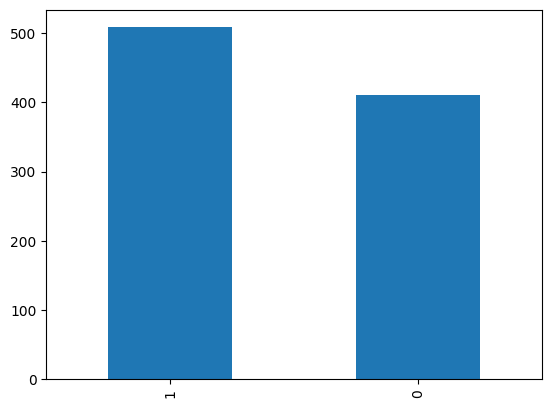

In [6]:
df.HeartDisease.value_counts().plot.bar()

Preprocess data:

In [7]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for categorical_feature in categorical_features:
  df[categorical_feature] = le.fit_transform(df[categorical_feature])

df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,1,140,289,0,1,172,0,0.0,2,0
1,49,0,2,160,180,0,1,156,0,1.0,1,1
2,37,1,1,130,283,0,2,98,0,0.0,2,0
3,48,0,0,138,214,0,1,108,1,1.5,1,1
4,54,1,2,150,195,0,1,122,0,0.0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,1,3,110,264,0,1,132,0,1.2,1,1
914,68,1,0,144,193,1,1,141,0,3.4,1,1
915,57,1,0,130,131,0,1,115,1,1.2,1,1
916,57,0,1,130,236,0,0,174,0,0.0,1,1


In [8]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler

# normalization
mms = MinMaxScaler()

# standardization
ss = StandardScaler()

for numerical_feature in numerical_features:
  df[numerical_feature] = mms.fit_transform(df[[numerical_feature]])
  df[numerical_feature] = ss.fit_transform(df[[numerical_feature]])

df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,-1.433140,1,1,0.410909,0.825070,0,1,1.382928,0,-0.832432,2,0
1,-0.478484,0,2,1.491752,-0.171961,0,1,0.754157,0,0.105664,1,1
2,-1.751359,1,1,-0.129513,0.770188,0,2,-1.525138,0,-0.832432,2,0
3,-0.584556,0,0,0.302825,0.139040,0,1,-1.132156,1,0.574711,1,1
4,0.051881,1,2,0.951331,-0.034755,0,1,-0.581981,0,-0.832432,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,-0.902775,1,3,-1.210356,0.596393,0,1,-0.188999,0,0.293283,1,1
914,1.536902,1,0,0.627078,-0.053049,1,1,0.164684,0,2.357094,1,1
915,0.370100,1,0,-0.129513,-0.620168,0,1,-0.857069,1,0.293283,1,1
916,0.370100,0,1,-0.129513,0.340275,0,0,1.461525,0,-0.832432,1,1


In [9]:
from sklearn.model_selection import train_test_split

labels = df['HeartDisease']
df = df[df.columns.drop(['HeartDisease','RestingBP','RestingECG'])]

x_train, x_test, y_train, y_test = train_test_split(df, labels, test_size=0.2)
x_train

,Age,Sex,ChestPainType,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
396,0.900464,0,3,-1.818435,1,0.243281,0,-0.832432,1
381,-0.372411,1,0,-1.818435,0,-0.660578,1,-0.363384,1
844,-0.160265,1,3,-0.117079,0,2.090296,0,-0.832432,1
282,-0.266338,0,2,0.193922,0,0.911350,1,1.043759,2
810,0.157954,0,1,0.468334,0,0.950648,0,0.480902,1
...,...,...,...,...,...,...,...,...,...
351,-1.114921,1,0,-1.818435,0,0.125386,1,-0.363384,2
148,-0.372411,1,1,-0.281726,0,0.911350,0,-0.832432,2
504,0.900464,1,0,0.102451,1,-0.974963,1,1.981855,0
266,-0.160265,1,0,0.907394,0,-1.053560,1,0.105664,1


In [10]:
from sklearn.linear_model import LogisticRegression

classifier_lr = LogisticRegression(random_state=0, C=10, penalty='l2')
classifier_lr

LogisticRegression(C=10, random_state=0)

Train:

In [11]:
classifier_lr.fit(x_train, y_train)

LogisticRegression(C=10, random_state=0)

Test:

Accuracy: 86.413 %


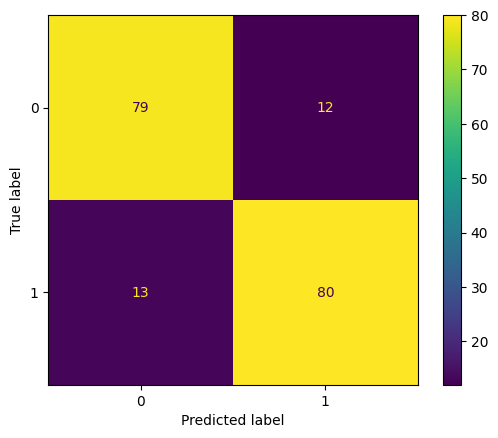

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predicted = classifier_lr.predict(x_test)
print(f'Accuracy: {accuracy_score(y_test, predicted)*100:.5} %')

cm = confusion_matrix(y_test, predicted)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot()
plt.show()

Interpret the model:

In [13]:
import shap

background_samples = shap.utils.sample(x_test, 100)  # 100 instances for use as the background distribution

# compute the SHAP values for the linear model
explainer = shap.Explainer(classifier_lr.predict, background_samples)
shap_values = explainer(x_test)
shap_values

ExactExplainer explainer: 185it [00:11,  6.88it/s]                         


.values =
array([[ 2.24642857e-02,  5.01309524e-02, -7.28928571e-02, ...,
         1.06773810e-01,  5.45952381e-02,  1.77202381e-01],
       [-1.18253968e-03, -1.07396825e-01, -5.89682540e-02, ...,
        -5.60634921e-02,  3.71031746e-03, -2.57242063e-01],
       [-5.52380952e-03,  8.07976190e-02, -9.63333333e-02, ...,
        -3.90357143e-02, -1.00000000e-03,  5.81476190e-01],
       ...,
       [-2.52896825e-02,  3.68055556e-02,  1.30150794e-01, ...,
         1.00865079e-01, -1.36230159e-02,  1.67686508e-01],
       [-4.22500000e-02, -1.25369048e-01,  4.38690476e-02, ...,
        -6.26547619e-02, -3.80000000e-02, -2.51535714e-01],
       [ 3.88095238e-03, -1.07095238e-01, -2.24916667e-01, ...,
        -5.15119048e-02, -1.19047619e-04, -1.89535714e-01]])

.base_values =
array([0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53,
       0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53,
       0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53

### Global:

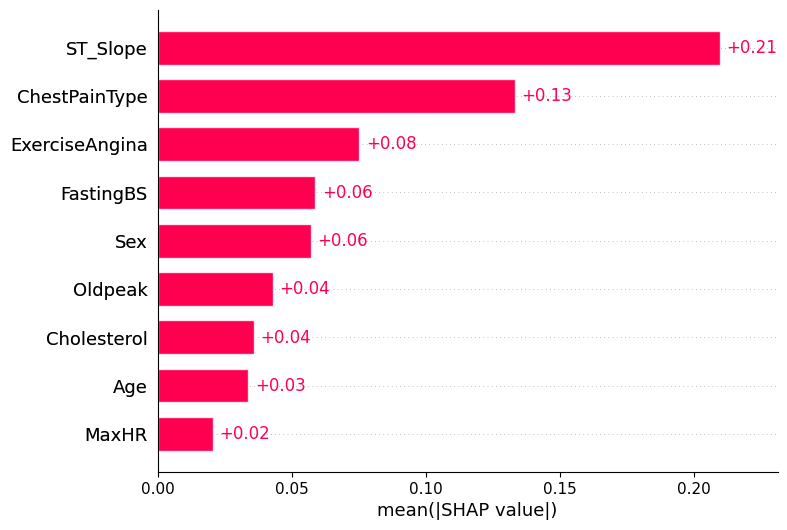

In [14]:
shap.plots.bar(shap_values)

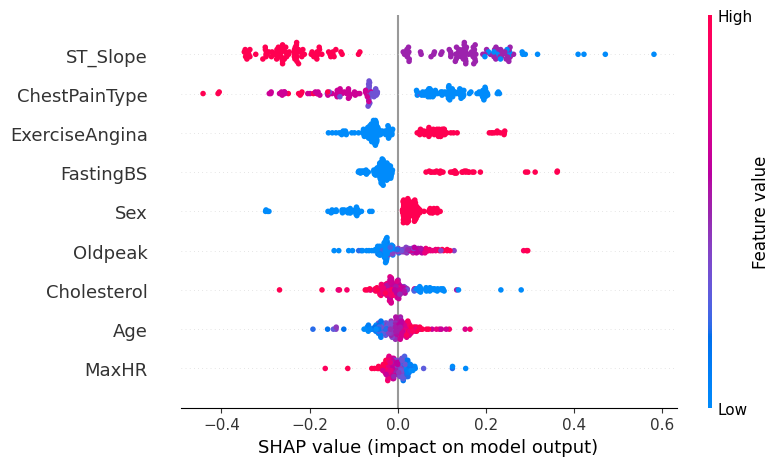

In [15]:
shap.plots.beeswarm(shap_values)

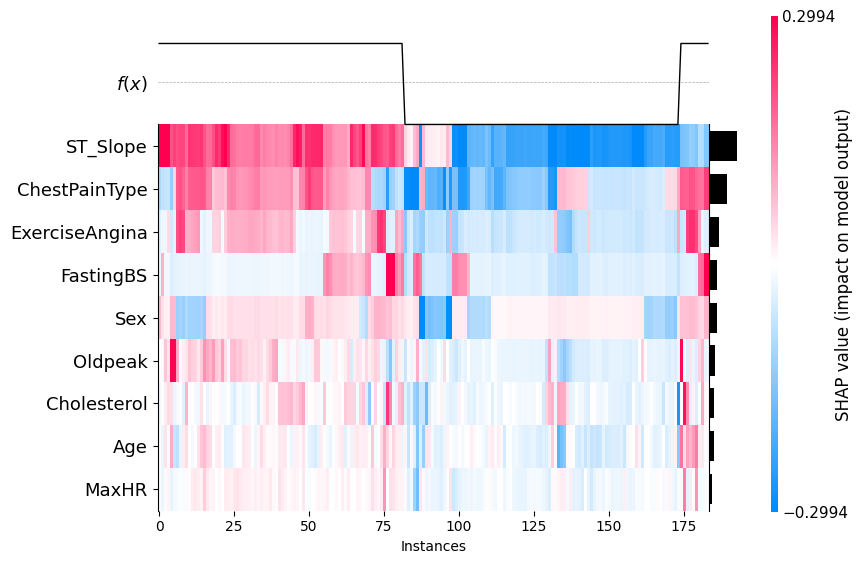

In [16]:
shap.plots.heatmap(shap_values)

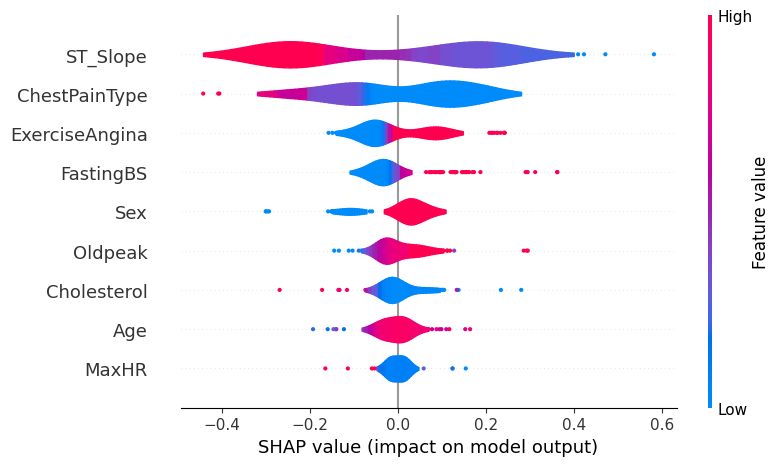

In [17]:
shap.plots.violin(shap_values)

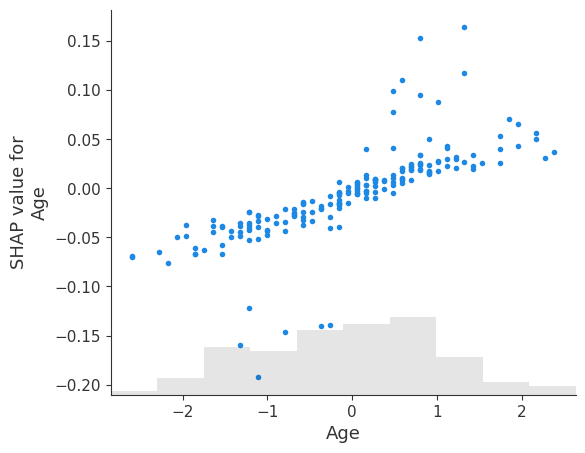

In [18]:
shap.plots.scatter(shap_values[:, 'Age'])

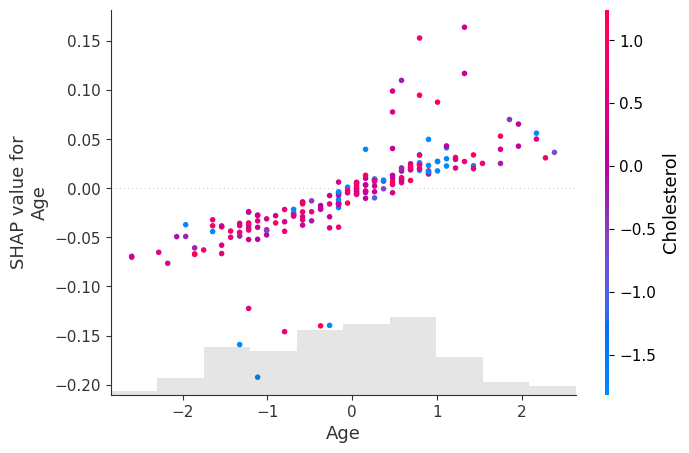

In [19]:
shap.plots.scatter(shap_values[:, 'Age'], color=shap_values)

### Local:

In [20]:
observation_of_interest = 42
x_test.iloc[observation_of_interest]

Age               0.794391
Sex               1.000000
ChestPainType     2.000000
Cholesterol       1.264130
FastingBS         0.000000
MaxHR            -1.525138
ExerciseAngina    1.000000
Oldpeak          -0.832432
ST_Slope          1.000000
Name: 602, dtype: float64

In [21]:
y_test.iloc[observation_of_interest]

1

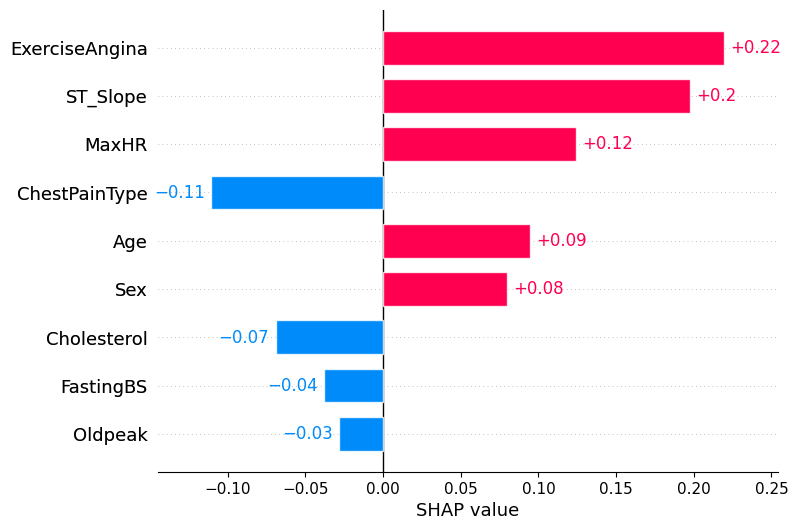

In [22]:
shap.plots.bar(shap_values[observation_of_interest])

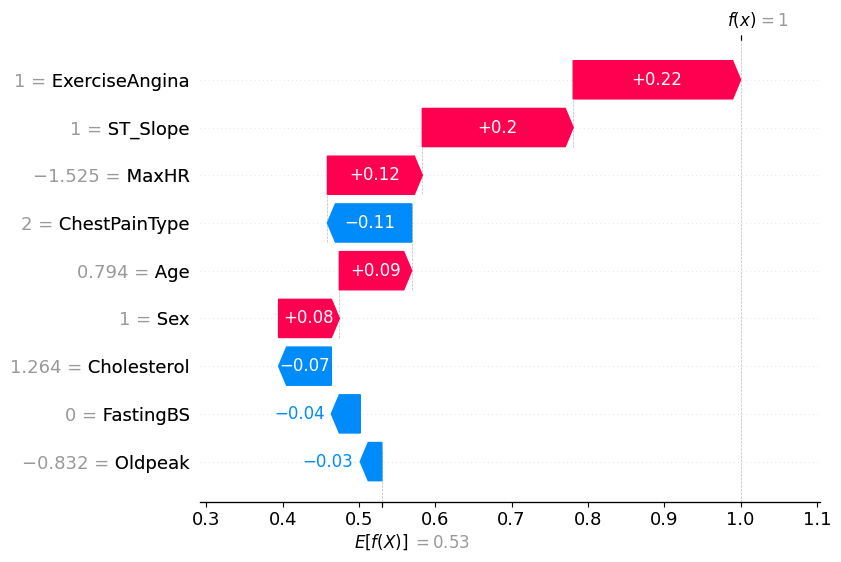

In [23]:
shap.plots.waterfall(shap_values[observation_of_interest])